In [0]:
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
import os
import string
import time

In [3]:
import keras
import sklearn
import tensorflow as tf

from keras import backend as K
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input, Lambda, LSTM, Masking, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

Using TensorFlow backend.


In [4]:
# Getting access to the dataset and the Python files on Google Drive.
# You will probably have to give permission.

from google.colab import drive
drive.mount('/content/gdrive')
root_folder = "/content/gdrive/My Drive/Project-Lion/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
df = pd.read_csv(root_folder + 'data/kaggle/shortjokes.csv')
df = df.loc[df["Joke"] != ""]

In [0]:
def clean_data(lst, in_place=True, keep_punc=""):
    if in_place:
        new_lst = lst
    else:
        new_lst = lst.copy()
        
    for i in range(len(new_lst)):
        joke = lst[i]
        joke = joke.replace("\r", " ").replace("\n", " ").replace("/", " or ")
        joke = joke.translate(str.maketrans("", "", string.punctuation.replace(keep_punc, ""))) # Remove punctuation
        joke = joke.lower() # Lowercase
        joke = ''.join(char for char in joke if not char.isdigit()) # Remove numbers
        joke = joke.strip() # Remove leading and ending whitespace
        new_lst[i] = joke
    return new_lst

In [0]:
data = clean_data(df["Joke"].tolist(), keep_punc="?")

#### Filter by QA jokes
#### Only keep jokes with a question length > 24 and an answer length > 4 

In [8]:
qa_all = [[s.strip() for s in list(filter(None, joke.split("?")))] for joke in data if len(list(filter(None, joke.split("?")))) == 2]
print(qa_all[0])

['why cant barbie get pregnant', 'because ken comes in a different box heyooooooo']


In [9]:
cnt = {}
for q, a in qa_all:
  if len(a.split()) not in cnt:
    cnt[len(a.split())] = 0
  cnt[len(a.split())] += 1
max(cnt, key=lambda x: cnt[x])

2

In [10]:
qa = [(q, a) for q, a in qa_all if len(q) >= 15 and len(a.split()) > 3 and len(a.split()) < 30]
print("Size of dataset:", len(qa))

Size of dataset: 60284


In [11]:
combined_qa = [q + " " + "starttok" + " " + a for q, a in qa]
tokenizer = Tokenizer(num_words=20000, oov_token="unktok")
tokenizer.fit_on_texts(combined_qa)
word2idx = tokenizer.word_index.copy()
idx2word = {key: value for value, key in word2idx.items()}
start_idx = word2idx['starttok']
unk_index = word2idx['unktok']
vocab_size = len(word2idx)
print("Vocab size:", vocab_size)
print(start_idx)
print(unk_index)
len(combined_qa)

Vocab size: 34050
2
1


60284

In [12]:
encoded = tokenizer.texts_to_sequences(combined_qa)
encoded_q, encoded_a = [], []

for i in range(len(encoded)):
    e = encoded[i]
    q_len = len(qa[i][0].split())
    e_q = e[:q_len]
    e_a = e[q_len:]
    encoded_q.append(e_q)
    encoded_a.append(e_a)


encoded_q = keras.preprocessing.sequence.pad_sequences(encoded_q, padding="post")
encoded_a = keras.preprocessing.sequence.pad_sequences(encoded_a, padding="post")
input_steps = encoded_q.shape[1]
output_steps = encoded_a.shape[1] - 1
data_size = encoded_q.shape[0]
idx2word[0] = 'PAD'

print(input_steps, output_steps, data_size)

47 29 60284


In [13]:
# testing that encoding and decoding are the same

idx2word[9910]

'deeds'

# Create Model

In [0]:
class KerasBatchGenerator(object):

  def __init__(self, input_data, target_data, input_steps, output_steps, batch_size, vocab_size):
    self.input_data = input_data
    self.target_data = target_data
    self.input_steps = input_steps
    self.output_steps = output_steps
    self.batch_size = batch_size
    self.vocab_size = vocab_size

  def generate(self):
    while True:
      idx = np.random.randint(self.input_data.shape[0] - batch_size - 1, size=batch_size)

      encoder_input = np.array([self.input_data[i] for i in idx])
      targets = np.array([self.target_data[i] for i in idx])
      decoder_input = targets[:, :-1]
      decoder_output = targets[:, 1:]
      
      #mask = np.expand_dims(decoder_output != 0, axis=2)
      #mask = decoder_output != 0
      decoder_output = tf.keras.utils.to_categorical(decoder_output, num_classes=self.vocab_size)
      #decoder_output = decoder_output.reshape(self.batch_size, self.output_steps, self.vocab_size)
      #decoder_output = decoder_output * mask
      
      yield [encoder_input, decoder_input], decoder_output

In [15]:
K.clear_session()

embed_dim = 128
latent_dim = 128

encoder_inputs = Input(shape=(input_steps,))
decoder_inputs = Input(shape=(output_steps,))

# add on
# encoder_masked = Masking(mask_value=0)(encoder_inputs)

# masked = Masking(mask_value=0)(decoder_inputs)



embedding = Embedding(vocab_size, embed_dim, mask_zero=True)
embedding2 = Embedding(vocab_size, embed_dim, mask_zero=True)

# enc_embed = embedding(encoder_masked)
enc_embed = embedding(encoder_inputs)
# dec_embed = embedding(masked)
dec_embed = embedding2(decoder_inputs)

encoder_LSTM = LSTM(latent_dim, dropout=0.2, recurrent_dropout=0.2, return_state=True)
_, encoder_h, encoder_c = encoder_LSTM(enc_embed)

decoder_LSTM = LSTM(latent_dim, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)
decoder_outputs = decoder_LSTM(dec_embed, initial_state=[encoder_h, encoder_c])


time_distr = TimeDistributed(Dense(vocab_size, activation='softmax'))
outputs = time_distr(decoder_outputs)
#decoder_dense = Dense(vocab_size, activation='softmax')
#outputs = decoder_dense(decoder_outputs)

model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)
model.compile(loss = "categorical_crossentropy", optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 47)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 29)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 47, 128)      4358400     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embeddin

In [0]:
batch_size = 64
num_epochs = 10
train_size = data_size * 4 // 5
train_steps_per_epoch = 100 # train_size // batch_size
valid_steps_per_epoch = 10 

train_q, train_a = encoded_q[:train_size], encoded_a[:train_size]
valid_q, valid_a = encoded_q[train_size:], encoded_a[train_size:]

#train_q, train_a = encoded_q[:10 * 32], encoded_a[:10 * 32]
#valid_q, valid_a = encoded_q[10 * 32:], encoded_a[10 * 32:]

train_data_generator = KerasBatchGenerator(train_q, train_a, input_steps, output_steps, batch_size, vocab_size)
valid_data_generator = KerasBatchGenerator(valid_q, valid_a, input_steps, output_steps, batch_size, vocab_size)

In [0]:
# unit test for KerasBatchGenerator
batches = train_data_generator.generate()
one_batch = None
for batch in batches:
  one_batch = batch
  break

In [0]:
# model.load_weights(root_folder + 'models/keras_model.h5')
plot_info_path = root_folder+"plots/keras_model_history.csv"

In [0]:
plot_info = pd.DataFrame(columns=['training_err', 'validation_err', 'training_acc', 'validation_acc'])

while True:
  history = model.fit_generator(train_data_generator.generate(), train_steps_per_epoch, epochs=num_epochs,
                          validation_data=valid_data_generator.generate(), validation_steps=valid_steps_per_epoch)
  print("saving model weights ....")
  model.save(root_folder + 'models/keras_model_2.h5')
  print("saving model weights completed....")
  print("saving plot info ....")
  training_acc = history.history['acc']
  validation_acc = history.history['val_acc']
  training_loss = history.history['loss']
  validation_loss = history.history['val_loss']
  rows = np.array([training_loss, validation_loss, training_acc, validation_acc]).T
  df_temp = pd.DataFrame(rows, columns=plot_info.columns)
  plot_info = plot_info.append(df_temp, ignore_index=True)
  plot_info.to_csv(plot_info_path, index=False)
  print("saving plot info completed ....")

Epoch 1/10
100/100 [==============================] - 55s 550ms/step - loss: 6.2729 - acc: 0.1315 - val_loss: 6.2503 - val_acc: 0.1382
Epoch 2/10
100/100 [==============================] - 54s 540ms/step - loss: 6.2291 - acc: 0.1324 - val_loss: 6.2105 - val_acc: 0.1366
Epoch 3/10
100/100 [==============================] - 53s 530ms/step - loss: 6.1833 - acc: 0.1344 - val_loss: 6.1935 - val_acc: 0.1406
Epoch 4/10
100/100 [==============================] - 53s 531ms/step - loss: 6.1385 - acc: 0.1376 - val_loss: 6.2364 - val_acc: 0.1408
Epoch 5/10
100/100 [==============================] - 53s 531ms/step - loss: 6.1248 - acc: 0.1402 - val_loss: 6.1039 - val_acc: 0.1378
Epoch 6/10
100/100 [==============================] - 53s 532ms/step - loss: 6.0628 - acc: 0.1478 - val_loss: 6.1913 - val_acc: 0.1430
Epoch 7/10
100/100 [==============================] - 53s 527ms/step - loss: 6.0517 - acc: 0.1526 - val_loss: 6.1219 - val_acc: 0.1503
Epoch 8/10
100/100 [==============================] - 5

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_4:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


saving model weights completed....
saving plot info ....
saving plot info completed ....
Epoch 1/10
100/100 [==============================] - 54s 538ms/step - loss: 5.9447 - acc: 0.1598 - val_loss: 5.9376 - val_acc: 0.1594
Epoch 2/10
100/100 [==============================] - 53s 528ms/step - loss: 5.8833 - acc: 0.1622 - val_loss: 5.9543 - val_acc: 0.1524
Epoch 3/10
100/100 [==============================] - 53s 532ms/step - loss: 5.8271 - acc: 0.1657 - val_loss: 5.9377 - val_acc: 0.1598
Epoch 4/10
100/100 [==============================] - 53s 530ms/step - loss: 5.8062 - acc: 0.1717 - val_loss: 5.7672 - val_acc: 0.1744
Epoch 5/10
100/100 [==============================] - 53s 527ms/step - loss: 5.6950 - acc: 0.1777 - val_loss: 5.6890 - val_acc: 0.1803
Epoch 6/10
100/100 [==============================] - 52s 520ms/step - loss: 5.6139 - acc: 0.1837 - val_loss: 5.6675 - val_acc: 0.1744
Epoch 7/10
100/100 [==============================] - 52s 518ms/step - loss: 5.5399 - acc: 0.1899 - v

In [0]:
def plot_loss_acc(hist):
    f, ax = plt.subplots()
    ax.plot([None] + hist.history['acc'], 'o-')
    ax.plot([None] + hist.history['val_acc'], 'x-')
    # Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Train acc', 'Validation acc'], loc = 0)
    ax.set_title('Training/Validation acc per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Acc') 
    plt.plot()
    
    f, ax = plt.subplots()
    ax.plot([None] + hist.history['loss'], 'o-',c='r')
    ax.plot([None] + hist.history['val_loss'], 'x-',c='g')
    # Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Train loss', 'Validation loss'], loc = 0)
    ax.set_title('Training/Validation loss per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Acc') 
    plt.plot()

[]

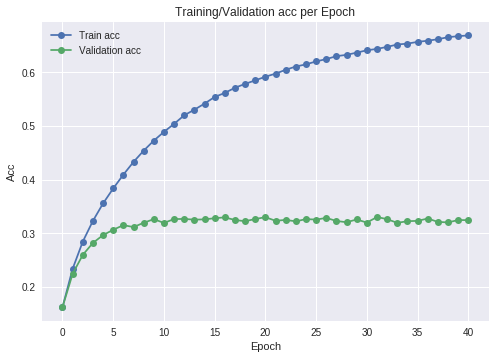

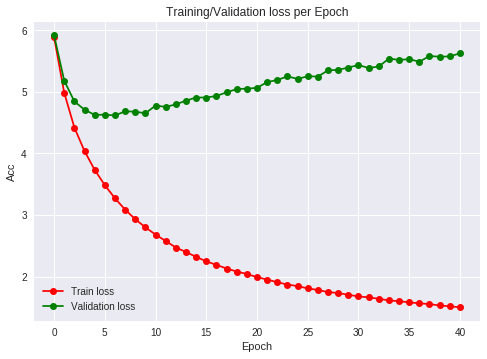

In [23]:
history = pd.read_csv(plot_info_path)
history = history.groupby(np.arange(len(history))//20).mean()
f, ax = plt.subplots()
ax.plot(history['training_acc'], 'o-')
ax.plot(history['validation_acc'], 'o-')
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train acc', 'Validation acc'], loc = 0)
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Acc') 
plt.plot()

f, ax = plt.subplots()
ax.plot(history['training_err'], 'o-',c='r')
ax.plot(history['validation_err'], 'o-',c='g')
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train loss', 'Validation loss'], loc = 0)
ax.set_title('Training/Validation loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Acc') 
plt.plot()

In [0]:
model.save(root_folder + 'models/keras_model.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_4:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


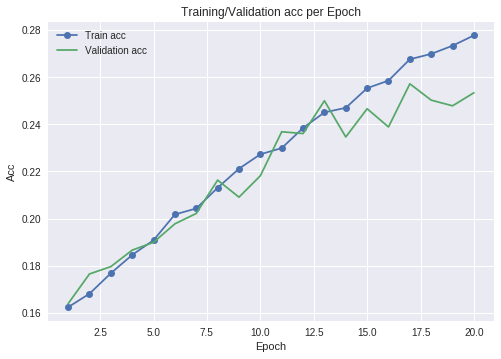

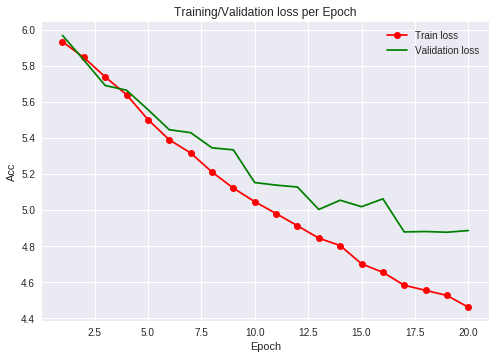

In [0]:
plot_loss_acc(history)

# Create Model 2

In [0]:
def build_batch(dataset, batch_size):
    """ Builds a batch of source and target elements from the dataset.
    
        Arguments:
            dataset: List[db_element] -- A list of dataset elements
            batch_size: int -- The size of the batch that should be created
        Returns:
            batch_input: List[List[int]] -- List of source sequences
            batch_target: List[List[int]] -- List of target sequences
            batch_target_mask: List[List[int]] -- List of target batch masks
    """
    
    indices = list(np.random.randint(0, len(dataset[0]), size=batch_size))
    
    # Recover what the entries for the batch are
    batch_encoder, batch_decoder = np.array([dataset[0][i] for i in indices]), np.array([dataset[1][i] for i in indices])

    batch_target = batch_decoder[:, 1:]
    
    # The target should be the un-shifted numerized input
    batch_encoder_input = np.array(batch_encoder)
    batch_decoder_input = batch_decoder[:, :-1]

    # The target-mask is a 0 or 1 filter to note which tokens are
    # padding or not, to give the loss, so the model doesn't get rewarded for
    # predicting PAD tokens.
    batch_target_mask = batch_target != 0
    
        
    return batch_encoder_input, batch_decoder_input, batch_target, batch_target_mask

In [0]:
# Using a basic RNN/LSTM for Language modeling
class LanguageModel():
    def __init__(self, input_length, output_length, vocab_size, rnn_size, batch_size=512, learning_rate=1e-5):
        
        self.encoder_input = tf.placeholder(tf.int32, shape=[None, input_length])
        self.decoder_input = tf.placeholder(tf.int32, shape=[None, output_length])
        self.targets = tf.placeholder(tf.int32, shape=[None, output_length])
        self.targets_mask = tf.placeholder(tf.int32, shape=[None, output_length])
        self.dropout = tf.placeholder_with_default(1.0, shape=())
        self.batch_size = batch_size
        self.decoder_lengths = tf.placeholder(tf.int32, shape=(self.batch_size))

        
        embedding = tf.get_variable("embedding", [vocab_size, rnn_size], dtype=tf.float32)
        
        encoder_emb = tf.nn.embedding_lookup(embedding, self.encoder_input)
        decoder_emb = tf.nn.embedding_lookup(embedding, self.decoder_input)
        
        encoder_cell = tf.nn.rnn_cell.LSTMCell(rnn_size)
        dropout_cell = tf.nn.rnn_cell.DropoutWrapper(encoder_cell, input_keep_prob=1.0, output_keep_prob=self.dropout)
        _, encoder_state = tf.nn.dynamic_rnn(dropout_cell, encoder_emb, dtype=tf.float32)
        
        decoder_cell = tf.nn.rnn_cell.LSTMCell(rnn_size)
        decoder_cell = tf.nn.rnn_cell.DropoutWrapper(decoder_cell, input_keep_prob=1.0, output_keep_prob=self.dropout)
        output_layer = tf.layers.Dense(vocab_size)
        
        with tf.variable_scope("decode"):
          training_helper = tf.contrib.seq2seq.TrainingHelper(decoder_emb, self.decoder_lengths)
          training_decoder = tf.contrib.seq2seq.BasicDecoder(decoder_cell, training_helper, encoder_state, output_layer)
          training_decoder_output = tf.contrib.seq2seq.dynamic_decode(training_decoder)[0]
          
        with tf.variable_scope("decode", reuse=True):
          start_tokens = tf.tile(tf.constant([start_idx], dtype=tf.int32), [self.batch_size], name='start_tokens')
          inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(embedding, start_tokens, end_idx)
          inference_decoder = tf.contrib.seq2seq.BasicDecoder(decoder_cell, inference_helper, encoder_state, output_layer)
          inference_decoder_output = tf.contrib.seq2seq.dynamic_decode(inference_decoder)[0]
                  
        self.training_logits = tf.identity(training_decoder_output.rnn_output)
        self.inference_logits = tf.identity(inference_decoder_output.sample_id)
        
        print(self.training_logits.shape)
        print(inference_decoder_output.rnn_output.shape)
        print(self.inference_logits.shape)
        print(self.decoder_lengths)
                
        self.loss = tf.contrib.seq2seq.sequence_loss(self.training_logits, self.targets, weights=tf.cast(self.targets_mask, dtype=tf.float32))
        self.global_step = tf.Variable(0, trainable=False)
        learning_rate = tf.train.exponential_decay(learning_rate, self.global_step, 100000, 0.96)
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

        self.train_op = optimizer.minimize(self.loss, global_step=self.global_step)
        self.saver = tf.train.Saver()

In [0]:
train_size = 10000
d_train = [encoded_q[:train_size], encoded_a[:train_size]]
d_valid = [encoded_q[train_size:], encoded_a[train_size:]]

In [0]:
tf.reset_default_graph() # This is so that when you debug, you reset the graph each time you run this, in essence, cleaning the board

save_file1 = root_folder+"models/qa_model"

batch_size = 512
epochs = 1

iter_per_epoch = 1 # len(d_train[0]) // batch_size
total_iterations = iter_per_epoch * epochs
print_per_iter = 1
eval_per_iter = 1

save_per_iter = 19

model = LanguageModel(input_length=input_steps, output_length=output_steps - 1, vocab_size=vocab_size, rnn_size=1028, learning_rate=1e-5, batch_size=batch_size)

print("Total iterations:", total_iterations)

train_losses = []
val_losses = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for epoch in range(1, epochs + 1):
        print("Epoch:", epoch)
        for _ in range(iter_per_epoch):
            batch_encoder_input, batch_decoder_input, batch_target, batch_target_mask = build_batch(d_train, batch_size)
            decoder_lens = np.ones((batch_size), dtype=int) * (output_steps - 1)
            feed = {model.encoder_input: batch_encoder_input, model.decoder_input: batch_decoder_input, model.targets: batch_target, model.targets_mask: batch_target_mask, model.decoder_lengths: decoder_lens}

            step, train_loss, _ = sess.run([model.global_step, model.loss, model.train_op], feed_dict=feed)
            train_losses.append(train_loss)

            if iteration % print_per_iter == 0:
                print("Iteration {0} / {1}: Training loss - {2}".format(iteration, total_iterations, train_loss))
            
            if iteration % eval_per_iter == 0:
                batch_encoder_input, batch_decoder_input, batch_target, batch_target_mask = build_batch(d_valid, batch_size)
                feed = {model.encoder_input: batch_encoder_input, model.decoder_input: batch_decoder_input, model.targets: batch_target, model.targets_mask: batch_target_mask, model.decoder_lengths: decoder_lens}
                eval_loss = sess.run([model.loss], feed_dict=feed)[0]
                print("Evaluation loss:", eval_loss)
                val_losses.append(eval_loss)
              
            if iteration % save_per_iter == 0:
              model.saver.save(sess, save_file1)
            
            iteration += 1
    
        

In [0]:
with tf.Session() as sess:
    model.saver.restore(sess, save_file1)
    answer_logits = sess.run(model.inference_logits, {model.encoder_input: encoded_q[512:1024]})
    print(model.)


print(answer_logits)

In [0]:
a = answer_logits[0]
print(" ".join(idx2word[i] for i in a))

In [0]:
np.ones((11), dtype=int) * 4

# Create Model 3

# Etc

In [0]:
def try_prediction(idx):
  question = encoded_q[idx]
  question = question.reshape(1, question.shape[0])
  print([idx2word[j] for j in question[0]])
  answer = np.zeros((1, output_steps))
  answer[0, 0] = start_idx
  final_ans = []
  
  for i in range(1, output_steps):
    pred = model.predict([question, answer])[0]
    pred = np.argmax(pred[i][:])
    if pred == 0:
      break
    answer[0, i] = pred
    final_ans.append(idx2word[pred])
  
  return " ".join(final_ans)

In [0]:
print(try_prediction(100))

['did', 'you', 'hear', 'about', 'the', 'calendar', 'thief', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
its got a unktok


In [0]:
def try_prediction2(question):
  question = encoded_q[idx]
  question = question.reshape(1, question.shape[0])
  print([idx2word[j] for j in question[0]])
  answer = np.zeros((1, output_steps))
  answer[0, 0] = start_idx
  final_ans = []
  
  for i in range(1, output_steps):
    pred = model.predict([question, answer])[0]
    pred = np.argmax(pred[i][:])
    if pred == 0:
      break
    answer[0, i] = pred
    final_ans.append(idx2word[pred])
  
  return " ".join(final_ans)

In [0]:
question = encoded_q[1332]
answer = np.zeros(output_steps)
answer[0] = start_idx
x=model.predict([question.reshape(1, question.shape[0]), answer.reshape(1, answer.shape[0])])
x=x[0,:,:]
x

array([[1.5944084e-06, 1.9723384e-06, 7.2512470e-02, ..., 1.9946933e-06,
        1.9792726e-06, 2.1494882e-06],
       [1.7733514e-06, 2.1303283e-06, 2.7423376e-01, ..., 2.2033059e-06,
        2.1994344e-06, 2.2096651e-06],
       [9.1821011e-07, 1.0012359e-06, 7.1588421e-01, ..., 1.0198935e-06,
        1.0360463e-06, 1.0040509e-06]], dtype=float32)

In [0]:
idx = 12
batch_size = 1
question = train_q[idx:idx+batch_size]
target = train_a[idx:idx+batch_size]

answer = np.zeros(target.shape)
answer[0] = start_idx

target = np.hstack((target[:, 1:], np.zeros((batch_size, 1))))
mask = np.expand_dims(target != 0, axis=2)
target = tf.keras.utils.to_categorical(target, num_classes=vocab_size)
#decoder_output = decoder_output.reshape(self.batch_size, self.output_steps, self.vocab_size)
target = target * mask

x=model.evaluate([question, answer], target, batch_size=batch_size)
x

In [0]:
time_distr.get_weights()[0]

array([[-0.03242446, -0.03689044,  0.02070518, ..., -0.02664001,
        -0.02547399, -0.04266471],
       [ 0.01969255,  0.0043085 ,  0.02838571, ...,  0.00485123,
         0.00916836,  0.00837918],
       [-0.01861973, -0.02951997,  0.0206966 , ..., -0.02430052,
        -0.01736492, -0.0136068 ],
       ...,
       [-0.03084927, -0.03844005,  0.01711964, ..., -0.01318076,
        -0.03721153, -0.01690714],
       [-0.00906306, -0.01056273,  0.01533686, ..., -0.01586072,
        -0.04339187, -0.01238717],
       [-0.02492933, -0.03824919,  0.01621732, ..., -0.00960355,
        -0.01371659, -0.03072176]], dtype=float32)

In [0]:
K.clear_session()

embed_dim = 128
latent_dim = 512

encoder_inputs = Input(shape=(input_steps,))
decoder_inputs = Input(shape=(output_steps,))
embedding = Embedding(vocab_size, embed_dim)
enc_embed = embedding(encoder_inputs)
dec_embed = embedding(decoder_inputs)

encoder_LSTM = LSTM(latent_dim, dropout=0.2, recurrent_dropout=0.2, return_state=True)
_, encoder_h, encoder_c = encoder_LSTM(enc_embed)


decoder_LSTM = LSTM(latent_dim, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)
decoder_outputs = decoder_LSTM(dec_embed, initial_state=[encoder_h, encoder_c])

time_distr = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder_outputs)
outputs = Lambda(crop_outputs, output_shape=(output_steps, vocab_size))([outputs, decoder_inputs])
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

[4.720688195902767e-08, 0.6039999723434448]

In [0]:
K.cast(K.not_equal(train_a, 0), dtype=K.floatx())

<tf.Tensor 'Cast:0' shape=(70297, 36) dtype=float32>

In [0]:
a = np.hstack((train_a[:1][:, 1:], np.zeros((1, 1))))
mask = a != 0
a = tf.keras.utils.to_categorical(a, num_classes=vocab_size)
#a = a.reshape(1, output_steps, vocab_size)

a = a * np.expand_dims(mask, axis=2)

In [0]:
mask.shape

(1, 36)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [0]:
train_a[:1]

array([[    1,    20,  2463,   283,     9,     2,   870,   581, 16592,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0]],
      dtype=int32)

In [0]:
np.sum(a[0, 7, :])

1.0

In [0]:
vocab_size

44467

In [0]:
len(idx2word)

44467

In [0]:
idx2word[0]

KeyError: ignored